#Plant Disease Detection Classifier Using CNN

##Installing Dependendencies and Libraries

Installing kaggle and mounting key to download dateset from kaggle.com

In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

Importing libraries

In [19]:
import tensorflow as tf
import cv2

from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from keras import backend as K

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Get project files
# Use this in google colab
! kaggle datasets download tulasidhanush/tomato-plant-villagesmall

! unzip tomato-plant-villagesmall.zip

In [3]:
# Variables for pre-processing and training.
batch_size = 32
epochs = 40
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_DEPTH = 3
INIT_LR = 1e-3

default_image_size = tuple((256, 256))
image_size = 0
directory_root = 'data/'

In [4]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [5]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = os.listdir(directory_root)

    for plant_disease_folder in root_dir :
        print(f"[INFO] Processing {plant_disease_folder} ...")
        plant_disease_image_list = os.listdir(f"{directory_root}/{plant_disease_folder}")

        for image in plant_disease_image_list[:250]:
            image_directory = f"{directory_root}/{plant_disease_folder}/{image}"
            if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                image_list.append(convert_image_to_array(image_directory))
                label_list.append(plant_disease_folder)

    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Tomato_Bacterial_spot ...
[INFO] Processing Tomato_Early_blight ...
[INFO] Processing Tomato_healthy ...
[INFO] Processing Tomato_Late_blight ...
[INFO] Processing Tomato_Leaf_Mold ...
[INFO] Processing Tomato_Septoria_leaf_spot ...
[INFO] Processing Tomato_Spider_mites_Two_spotted_spider_mite ...
[INFO] Processing Tomato__Target_Spot ...
[INFO] Processing Tomato__Tomato_mosaic_virus ...
[INFO] Processing Tomato__Tomato_YellowLeaf__Curl_Virus ...
[INFO] Image loading completed


In [6]:
image_size = len(image_list)

In [7]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
n_classes = len(label_binarizer.classes_)

print(label_binarizer.classes_)

['Tomato_Bacterial_spot' 'Tomato_Early_blight' 'Tomato_Late_blight'
 'Tomato_Leaf_Mold' 'Tomato_Septoria_leaf_spot'
 'Tomato_Spider_mites_Two_spotted_spider_mite' 'Tomato__Target_Spot'
 'Tomato__Tomato_YellowLeaf__Curl_Virus' 'Tomato__Tomato_mosaic_virus'
 'Tomato_healthy']


In [8]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [9]:
X_train, X_rem, y_train, y_rem = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)

In [10]:
aug = ImageDataGenerator(rotation_range=25,
                          width_shift_range=0.1,
                          height_shift_range=0.1,
                          shear_range=0.2,
                          zoom_range=0.2,
                          horizontal_flip=True,
                          fill_mode='nearest'
)

In [18]:
resize_and_rescale = Sequential([
  Resizing(IMG_HEIGHT, IMG_WIDTH)
  Rescaling(1.0/255)
])

SyntaxError: invalid syntax (<ipython-input-18-afddc886f804>, line 3)

In [11]:
model = Sequential()
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH)

model.add(Conv2D(32, (3, 3), activation="relu", padding="same",input_shape=input_shape))
model.add(MaxPooling2D((3, 3)))

model.add(Conv2D(64, (3, 3), activation="relu", padding="same"))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation="relu", padding="same"))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation="relu", padding="same"))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation="relu", padding="same"))
model.add(MaxPooling2D((2, 2)))


model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dense(n_classes, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 42, 42, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 42, 42, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 21, 21, 64)       0

In [12]:
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / epochs)

model.compile(loss="binary_crossentropy", 
              optimizer=opt,
              metrics=["accuracy"])

In [13]:
history = model.fit(aug.flow(X_train, y_train, batch_size=batch_size),
                                validation_data=(X_valid, y_valid),
                                steps_per_epoch=len(X_train) // batch_size,
                                epochs=epochs, 
                                verbose=1
)

Epoch 1/40
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
62/62 [==============================] - ETA: 0s - loss: 0.3582 - accuracy: 0.1042WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000002724FE52948> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) 

KeyboardInterrupt: 

In [ ]:
model.save('plant_disease_detetion_classifier_3.h5')

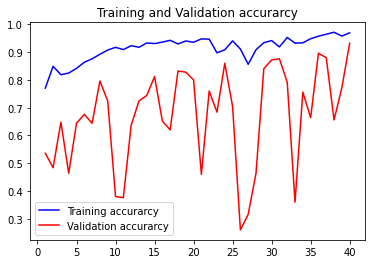

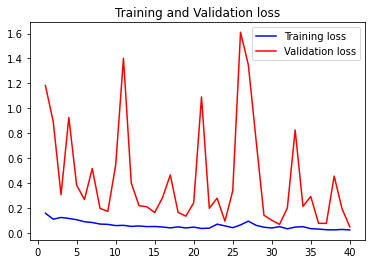

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [ ]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
8/8 [==============================] - 0s 20ms/step - loss: 0.0491 - accuracy: 0.9160
Test Accuracy: 91.60000085830688


In [ ]:
scores

[0.04906482994556427, 0.9160000085830688]